# Proportional Symbol Map - Catalan Municipal Elections

This notebook creates a proportional symbol map (pie chart map) showing election results for Catalan municipalities.

Each municipality is represented by a pie chart where:
- **Size** = Total votes (proportional)
- **Slices** = Percentage of votes per party

In [18]:
# Install required packages
print("Installing required packages...")
print("This may take a minute...\n")

!pip install pandas folium matplotlib numpy geopy
print("\n✅ Packages installed successfully!")

Installing required packages...
This may take a minute...


✅ Packages installed successfully!


In [19]:
import pandas as pd
import numpy as np
import folium
from folium import plugins
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from io import BytesIO
import base64
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")


Libraries imported successfully!


## 1. Load Prepared Data


In [20]:
# Load the prepared election data
# First check if we have a version with coordinates already
import os

coords_file = 'data/election_data_with_coords.csv'
prepared_file = 'data/election_data_prepared_2019.csv'

if os.path.exists(coords_file):
    print(f"Found coordinates file: {coords_file}")
    print("Loading data with coordinates...")
    df = pd.read_csv(coords_file)
    print(f"✅ Loaded {len(df)} municipalities with coordinates")
else:
    print(f"Loading prepared data from: {prepared_file}")
    df = pd.read_csv(prepared_file)
    print(f"Loaded {len(df)} municipalities")

print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())


Found coordinates file: data/election_data_with_coords.csv
Loading data with coordinates...
✅ Loaded 947 municipalities with coordinates

Columns: ['MUNICIPI', 'PSC-CP', 'ERC-AM', 'JUNTS', 'Cs', 'PP', 'Others', 'total_votes', 'latitude', 'longitude']

First few rows:
             MUNICIPI  PSC-CP  ERC-AM  JUNTS   Cs   PP  Others  total_votes  \
0  Abella de la Conca       0      64      0    0    0      58          122   
1              Abrera    3006     810      0  426  192    1378         5812   
2            Agramunt       0       0      0    0    0    2326         2326   
3  Aguilar de Segarra       0       0    123    0    0      60          183   
4            Agullana       0     129    230    0    0      96          455   

    latitude  longitude  
0  42.161459   1.092336  
1  41.520446   1.902413  
2  41.787076   1.098512  
3  41.739490   1.631668  
4  42.393841   2.846917  


## 2. Get Geographic Coordinates

We need to geocode municipality names to get latitude and longitude coordinates.


In [21]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time

def geocode_municipality(municipality_name, region="Catalonia, Spain", max_retries=3):
    """Geocode a municipality name to get coordinates"""
    geolocator = Nominatim(user_agent="catalan_election_map")
    location_str = f"{municipality_name}, {region}"
    
    for attempt in range(max_retries):
        try:
            location = geolocator.geocode(location_str, timeout=10)
            if location:
                return location.latitude, location.longitude
            # Try without region if first attempt fails
            if attempt == 0:
                location = geolocator.geocode(municipality_name, timeout=10)
                if location:
                    return location.latitude, location.longitude
            return None, None
        except GeocoderTimedOut:
            if attempt < max_retries - 1:
                time.sleep(1)
            else:
                return None, None
    return None, None

# Check if coordinates already exist in the dataframe
has_coords = 'latitude' in df.columns and 'longitude' in df.columns
has_valid_coords = has_coords and df['latitude'].notna().any()

if has_valid_coords:
    print("✅ Coordinates already exist in the data!")
    municipalities_with_coords = df['latitude'].notna().sum()
    print(f"Municipalities with coordinates: {municipalities_with_coords}/{len(df)}")
    
    # Check if there are any missing coordinates
    missing_coords = df['latitude'].isna().sum()
    if missing_coords > 0:
        print(f"⚠️  {missing_coords} municipalities are missing coordinates.")
        print("   These will be skipped in the map.")
    else:
        print("   All municipalities have coordinates! 🎉")
else:
    print("⚠️  No coordinates found. Starting geocoding...")
    print("   This may take 10-15 minutes for all municipalities.\n")
    
    # Initialize coordinate columns if they don't exist
    if 'latitude' not in df.columns:
        df['latitude'] = None
    if 'longitude' not in df.columns:
        df['longitude'] = None
    
    # Geocode in batches to avoid rate limiting
    batch_size = 50
    total_batches = (len(df) + batch_size - 1) // batch_size
    
    for i in range(0, len(df), batch_size):
        batch = df.iloc[i:i+batch_size]
        batch_num = i // batch_size + 1
        print(f"Geocoding batch {batch_num}/{total_batches} ({i+1}-{min(i+batch_size, len(df))}/{len(df)})...")
        
        for idx in batch.index:
            if pd.isna(df.loc[idx, 'latitude']):  # Only geocode if missing
                lat, lon = geocode_municipality(df.loc[idx, 'MUNICIPI'])
                df.loc[idx, 'latitude'] = lat
                df.loc[idx, 'longitude'] = lon
                time.sleep(0.5)  # Rate limiting
        
        # Save progress after each batch
        df.to_csv('data/election_data_with_coords.csv', index=False)
        print(f"  Progress saved. Continuing...\n")
    
    print("✅ Geocoding complete!")
    print(f"Successfully geocoded: {df['latitude'].notna().sum()}/{len(df)} municipalities")
    print(f"Saved to: data/election_data_with_coords.csv")

# Filter to only municipalities with coordinates
df_mapped = df[df['latitude'].notna()].copy()
print(f"\n📍 Municipalities ready for mapping: {len(df_mapped)}")


✅ Coordinates already exist in the data!
Municipalities with coordinates: 947/947
   All municipalities have coordinates! 🎉

📍 Municipalities ready for mapping: 947


## 3. Create Pie Chart Function

We'll create pie charts as base64 encoded images to use as map markers.


In [22]:
def create_pie_chart(data_dict, total_votes, colors_dict, max_votes, min_votes, min_size=30, max_size=120):
    """
    Create a pie chart as a base64 encoded image
    
    Parameters:
    -----------
    data_dict : dict
        Dictionary with party names as keys and vote counts as values
    total_votes : float
        Total votes (used for sizing)
    colors_dict : dict
        Color mapping for each party
    max_votes : float
        Maximum votes across all municipalities (for scaling)
    min_votes : float
        Minimum votes across all municipalities (for scaling)
    min_size : int
        Minimum pixel size for the pie chart
    max_size : int
        Maximum pixel size for the pie chart
    
    Returns:
    --------
    tuple: (base64 encoded image string, pixel_size)
    """
    # Filter out zero values and Others if it's too small
    filtered_data = {k: v for k, v in data_dict.items() 
                     if v > 0 and k != 'total_votes' and k != 'MUNICIPI'}
    
    if not filtered_data:
        return None, None
    
    # Calculate pixel size based on total votes (square root scaling for better visual representation)
    if max_votes > min_votes:
        # Use square root scaling to avoid too large differences
        scale_factor = np.sqrt(total_votes / max_votes)
        pixel_size = int(min_size + (max_size - min_size) * scale_factor)
    else:
        pixel_size = (min_size + max_size) // 2
    
    # Create figure - use higher DPI for better quality
    fig, ax = plt.subplots(figsize=(pixel_size/100, pixel_size/100), facecolor='white', dpi=100)
    fig.patch.set_alpha(0)  # Transparent background
    
    # Prepare data for pie chart
    labels = list(filtered_data.keys())
    sizes = list(filtered_data.values())
    colors = [colors_dict.get(label, '#CCCCCC') for label in labels]
    
    # Create pie chart
    wedges, texts = ax.pie(sizes, colors=colors, startangle=90, 
                           radius=1, counterclock=False)
    
    # Remove labels (we'll show them in tooltip)
    for text in texts:
        text.set_visible(False)
    
    # Equal aspect ratio
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Convert to base64
    buf = BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0, 
                facecolor='white', transparent=True, dpi=100)
    buf.seek(0)
    img_str = base64.b64encode(buf.read()).decode('utf-8')
    plt.close(fig)
    
    return img_str, pixel_size

# Define colors for each party
party_colors = {
    'PSC-CP': '#E3000F',      # Red (Socialist)
    'ERC-AM': '#FFB81C',      # Orange/Yellow (Republican Left)
    'JUNTS': '#6B2C91',       # Purple (Junts)
    'Cs': '#FF6600',          # Orange (Citizens)
    'PP': '#1E84CE',          # Blue (People's Party)
    'Others': '#CCCCCC'       # Gray
}

print("Pie chart function created!")
print(f"Party colors: {party_colors}")


Pie chart function created!
Party colors: {'PSC-CP': '#E3000F', 'ERC-AM': '#FFB81C', 'JUNTS': '#6B2C91', 'Cs': '#FF6600', 'PP': '#1E84CE', 'Others': '#CCCCCC'}


## 4. Create Proportional Symbol Map - ALL Municipalities

This creates a map with all municipalities. This may take several minutes to generate all the pie chart markers.


### Option 1: Map with ALL Municipalities

This includes all municipalities with coordinates. Use this for the complete visualization.


Creating pie chart markers for each municipality...
This may take a few minutes for 947 municipalities...

  Added 50/947 markers...
  Added 100/947 markers...
  Added 150/947 markers...
  Added 200/947 markers...
  Added 250/947 markers...
  Added 300/947 markers...
  Added 350/947 markers...
  Added 400/947 markers...
  Added 450/947 markers...
  Added 500/947 markers...
  Added 550/947 markers...
  Added 600/947 markers...
  Added 650/947 markers...
  Added 700/947 markers...
  Added 750/947 markers...
  Added 800/947 markers...
  Added 850/947 markers...
  Added 900/947 markers...

Map created with 947 pie chart markers!
Map saved to: proportional_symbol_map_catalonia.html

You can open this file in a web browser or host it on GitHub Pages!



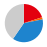
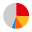
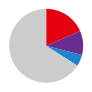
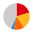
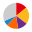
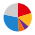
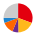
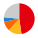
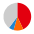
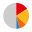
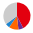
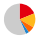
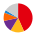
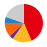
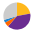
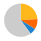
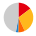
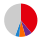
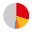
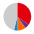
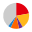
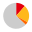
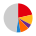
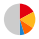
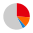
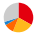
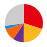
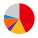
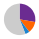
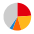
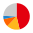
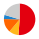
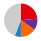
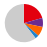
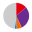
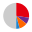
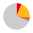
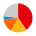
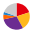
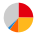

In [23]:
# Calculate center of Catalonia (approximate)
catalonia_center = [41.5912, 1.5209]  # Barcelona area, good center point

# Get min/max votes for scaling
max_votes = df_mapped['total_votes'].max()
min_votes = df_mapped['total_votes'].min()

# Create base map
m = folium.Map(
    location=catalonia_center,
    zoom_start=8,
    tiles='OpenStreetMap'
)

print("Creating pie chart markers for each municipality...")
print(f"This may take a few minutes for {len(df_mapped)} municipalities...\n")

# Add pie chart markers for each municipality
added_count = 0
for idx, row in df_mapped.iterrows():
    # Prepare data for pie chart
    party_cols = [col for col in df_mapped.columns 
                  if col not in ['MUNICIPI', 'total_votes', 'latitude', 'longitude']]
    
    data_dict = {col: row[col] for col in party_cols}
    total_votes = row['total_votes']
    
    # Create pie chart (pass max_votes and min_votes for scaling)
    pie_img, pixel_size = create_pie_chart(data_dict, total_votes, party_colors, max_votes, min_votes)
    
    if pie_img and pixel_size:
        # Create HTML for custom marker
        html = f'''
        <div style="text-align: center;">
            <strong>{row['MUNICIPI']}</strong><br>
            Total votes: {int(total_votes):,}<br>
            <img src="data:image/png;base64,{pie_img}" style="width:80px; height:80px;">
        </div>
        '''
        
        # Create popup with detailed information
        party_info = []
        for party in party_cols:
            if row[party] > 0:
                pct = (row[party] / total_votes * 100) if total_votes > 0 else 0
                party_info.append(f"{party}: {int(row[party]):,} ({pct:.1f}%)")
        
        popup_html = f'''
        <div style="font-family: Arial; width: 200px;">
            <h3>{row['MUNICIPI']}</h3>
            <p><strong>Total Votes:</strong> {int(total_votes):,}</p>
            <p><strong>Distribution:</strong></p>
            <ul>
                {"".join([f"<li>{info}</li>" for info in party_info])}
            </ul>
        </div>
        '''
        
        # Add marker with proportional size
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=folium.Popup(popup_html, max_width=250),
            tooltip=f"{row['MUNICIPI']} ({int(total_votes):,} votes)",
            icon=folium.DivIcon(
                html=f'<img src="data:image/png;base64,{pie_img}" style="width:{pixel_size}px; height:{pixel_size}px;">',
                icon_size=(pixel_size, pixel_size),
                icon_anchor=(pixel_size/2, pixel_size/2)
            )
        ).add_to(m)
        
        added_count += 1
        if added_count % 50 == 0:
            print(f"  Added {added_count}/{len(df_mapped)} markers...")

print(f"\nMap created with {added_count} pie chart markers!")

# Save map
output_file = 'proportional_symbol_map_catalonia.html'
m.save(output_file)
print(f"Map saved to: {output_file}")
print(f"\nYou can open this file in a web browser or host it on GitHub Pages!")

# Display the map
m


### Option 2: Map with TOP 50 Municipalities (Faster & Cleaner)

This creates a map with only the top 50 municipalities by total votes. 
- **Faster to generate** (fewer pie charts to create)
- **Cleaner visualization** (less cluttered map)
- **Good for presentations** (focuses on major municipalities)


Creating map with top 50 municipalities by total votes...
These represent the largest municipalities and will be faster to geocode.


Adding 50 pie chart markers...

Map saved to: proportional_symbol_map_catalonia_top50.html



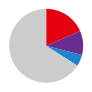
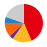
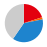
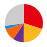
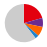
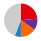
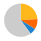
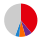
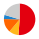
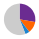
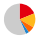
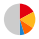
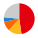
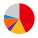
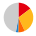
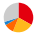
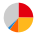
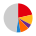
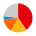
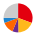
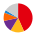
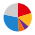
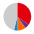
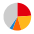
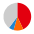
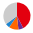
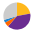
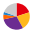
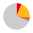
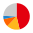
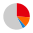
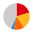
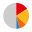
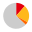
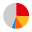
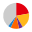
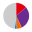
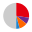
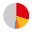
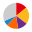

In [ ]:
# Option: Create map with only top N municipalities by total votes
# This is faster for testing and still creates a good visualization

TOP_N = 50  # Change this number as needed

# Get top municipalities
df_top = df_mapped.nlargest(TOP_N, 'total_votes').copy()

print(f"Creating map with top {TOP_N} municipalities by total votes...")
print(f"These represent the largest municipalities by voter turnout.\n")

# Filter to only municipalities with coordinates
df_top = df_top[df_top['latitude'].notna()].copy()
print(f"Municipalities ready for mapping: {len(df_top)}")

# Create map for top municipalities
m_top = folium.Map(
    location=catalonia_center,
    zoom_start=8,
    tiles='OpenStreetMap'
)

print(f"\nAdding {len(df_top)} pie chart markers...")

for idx, row in df_top.iterrows():
    party_cols = [col for col in df_top.columns 
                  if col not in ['MUNICIPI', 'total_votes', 'latitude', 'longitude']]
    
    data_dict = {col: row[col] for col in party_cols}
    total_votes = row['total_votes']
    
    # Get min/max for this subset
    max_votes_top = df_top['total_votes'].max()
    min_votes_top = df_top['total_votes'].min()
    
    pie_img, pixel_size = create_pie_chart(data_dict, total_votes, party_colors, max_votes_top, min_votes_top)
    
    if pie_img and pixel_size:
        party_info = []
        for party in party_cols:
            if row[party] > 0:
                pct = (row[party] / total_votes * 100) if total_votes > 0 else 0
                party_info.append(f"{party}: {int(row[party]):,} ({pct:.1f}%)")
        
        popup_html = f'''
        <div style="font-family: Arial; width: 200px;">
            <h3>{row['MUNICIPI']}</h3>
            <p><strong>Total Votes:</strong> {int(total_votes):,}</p>
            <p><strong>Distribution:</strong></p>
            <ul>
                {"".join([f"<li>{info}</li>" for info in party_info])}
            </ul>
        </div>
        '''
        
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=folium.Popup(popup_html, max_width=250),
            tooltip=f"{row['MUNICIPI']} ({int(total_votes):,} votes)",
            icon=folium.DivIcon(
                html=f'<img src="data:image/png;base64,{pie_img}" style="width:{pixel_size}px; height:{pixel_size}px;">',
                icon_size=(pixel_size, pixel_size),
                icon_anchor=(pixel_size/2, pixel_size/2)
            )
        ).add_to(m_top)

# Add legend
legend_html = '''
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 200px; height: auto; 
     background-color: white; z-index:9999; font-size:14px;
     border:2px solid grey; border-radius:5px; padding: 10px">
     <h4>Political Parties</h4>
     <p><span style="color: #E3000F;">■</span> PSC-CP</p>
     <p><span style="color: #FFB81C;">■</span> ERC-AM</p>
     <p><span style="color: #6B2C91;">■</span> JUNTS</p>
     <p><span style="color: #FF6600;">■</span> Cs</p>
     <p><span style="color: #1E84CE;">■</span> PP</p>
     <p><span style="color: #CCCCCC;">■</span> Others</p>
     <p><small>Circle size = Total votes</small></p>
</div>
'''
m_top.get_root().html.add_child(folium.Element(legend_html))

output_file_top = f'proportional_symbol_map_catalonia_top{TOP_N}.html'
m_top.save(output_file_top)
print(f"\n✅ Map saved to: {output_file_top}")
print(f"This map includes the top {len(df_top)} municipalities by total votes.")
print(f"You can open this file in a web browser or host it on GitHub Pages!")

m_top


### Option 3: Map with ALL Municipalities (Complete Dataset)

This creates a map with ALL municipalities that have coordinates. This is the complete visualization showing every municipality in the dataset.


Creating proportional symbol map with ALL municipalities...
This will include 947 municipalities.

Adding 947 pie chart markers...
This may take a few minutes...

  Added 100/947 markers...
  Added 200/947 markers...
  Added 300/947 markers...
  Added 400/947 markers...
  Added 500/947 markers...
  Added 600/947 markers...
  Added 700/947 markers...
  Added 800/947 markers...
  Added 900/947 markers...

✅ Map created with 947 pie chart markers!
✅ Map saved to: proportional_symbol_map_catalonia_all.html
This map includes ALL 947 municipalities with coordinates.
You can open this file in a web browser or host it on GitHub Pages!



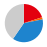
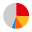
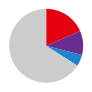
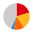
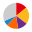
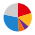
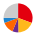
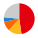
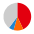
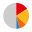
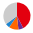
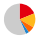
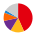
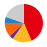
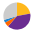
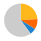
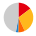
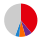
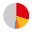
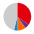
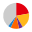
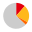
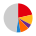
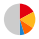
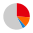
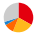
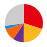
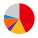
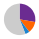
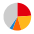
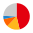
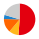
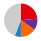
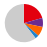
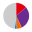
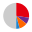
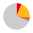
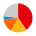
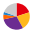
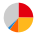

In [25]:
# Create map with ALL municipalities
# This includes every municipality with coordinates

print("Creating proportional symbol map with ALL municipalities...")
print(f"This will include {len(df_mapped)} municipalities.\n")

# Calculate center of Catalonia
catalonia_center = [41.5912, 1.5209]  # Barcelona area, good center point

# Get min/max votes for scaling
max_votes_all = df_mapped['total_votes'].max()
min_votes_all = df_mapped['total_votes'].min()

# Create base map
m_all = folium.Map(
    location=catalonia_center,
    zoom_start=8,
    tiles='OpenStreetMap'
)

print(f"Adding {len(df_mapped)} pie chart markers...")
print("This may take a few minutes...\n")

# Add pie chart markers for each municipality
added_count_all = 0
for idx, row in df_mapped.iterrows():
    # Prepare data for pie chart
    party_cols = [col for col in df_mapped.columns 
                  if col not in ['MUNICIPI', 'total_votes', 'latitude', 'longitude']]
    
    data_dict = {col: row[col] for col in party_cols}
    total_votes = row['total_votes']
    
    # Create pie chart (pass max_votes and min_votes for scaling)
    pie_img, pixel_size = create_pie_chart(data_dict, total_votes, party_colors, max_votes_all, min_votes_all)
    
    if pie_img and pixel_size:
        # Create popup with detailed information
        party_info = []
        for party in party_cols:
            if row[party] > 0:
                pct = (row[party] / total_votes * 100) if total_votes > 0 else 0
                party_info.append(f"{party}: {int(row[party]):,} ({pct:.1f}%)")
        
        popup_html = f'''
        <div style="font-family: Arial; width: 200px;">
            <h3>{row['MUNICIPI']}</h3>
            <p><strong>Total Votes:</strong> {int(total_votes):,}</p>
            <p><strong>Distribution:</strong></p>
            <ul>
                {"".join([f"<li>{info}</li>" for info in party_info])}
            </ul>
        </div>
        '''
        
        # Add marker with proportional size
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=folium.Popup(popup_html, max_width=250),
            tooltip=f"{row['MUNICIPI']} ({int(total_votes):,} votes)",
            icon=folium.DivIcon(
                html=f'<img src="data:image/png;base64,{pie_img}" style="width:{pixel_size}px; height:{pixel_size}px;">',
                icon_size=(pixel_size, pixel_size),
                icon_anchor=(pixel_size/2, pixel_size/2)
            )
        ).add_to(m_all)
        
        added_count_all += 1
        if added_count_all % 100 == 0:
            print(f"  Added {added_count_all}/{len(df_mapped)} markers...")

print(f"\n✅ Map created with {added_count_all} pie chart markers!")

# Add legend
legend_html_all = '''
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 200px; height: auto; 
     background-color: white; z-index:9999; font-size:14px;
     border:2px solid grey; border-radius:5px; padding: 10px">
     <h4>Political Parties</h4>
     <p><span style="color: #E3000F;">■</span> PSC-CP</p>
     <p><span style="color: #FFB81C;">■</span> ERC-AM</p>
     <p><span style="color: #6B2C91;">■</span> JUNTS</p>
     <p><span style="color: #FF6600;">■</span> Cs</p>
     <p><span style="color: #1E84CE;">■</span> PP</p>
     <p><span style="color: #CCCCCC;">■</span> Others</p>
     <p><small>Circle size = Total votes</small></p>
     <p><small>Catalan Municipal Elections 2019</small></p>
     <p><small>All Municipalities ({count} total)</small></p>
</div>
'''.replace('{count}', str(added_count_all))

m_all.get_root().html.add_child(folium.Element(legend_html_all))

# Save map
output_file_all = 'proportional_symbol_map_catalonia_all.html'
m_all.save(output_file_all)
print(f"✅ Map saved to: {output_file_all}")
print(f"This map includes ALL {added_count_all} municipalities with coordinates.")
print(f"You can open this file in a web browser or host it on GitHub Pages!")

# Display the map
m_all
